# 3D Simulation and fitting using gamma-ray spectral models and CTA-1DC IRFs

This notebooks simulates datasets assuming spectral-cutoff power law distributions of protons, and fits with both pl and ecpl. It stores the results, so that the analysis can be done elsewhere.

In [3]:
import gammapy
print(gammapy.__version__)

0.14


In [4]:
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from pathlib import Path
from regions import CircleSkyRegion
import multiprocessing
import itertools
from joblib import Parallel, delayed
import naima

In [5]:
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.modeling.models import PowerLawSpectralModel, ExpCutoffPowerLawSpectralModel, NaimaSpectralModel
from gammapy.modeling.models import PointSpatialModel
from gammapy.modeling.models import SkyModel, BackgroundModel
from gammapy.modeling import Fit
from gammapy.cube import MapDataset, PSFKernel
from gammapy.data import FixedPointingInfo
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf

In [6]:
num_cores = multiprocessing.cpu_count()
num_cores

8

## CTA IRFs and observation parameters

In [7]:
LIVETIME = 10 * u.hour

In [12]:
# filename = (
#     "./cta/prod3b-v1/bcf/South_z20_average_5h/irf_file.fits"
# )
# # Define some observation parameters
# # We read in the pointing info from one of the 1dc event list files as an example
# pointing = FixedPointingInfo.read(
#     "/home/luca/GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_110380.fits"
# )
# irfs = load_cta_irfs(filename)
filename = (
    "./irf_file.fits"
)
# Define some observation parameters
# We read in the pointing info from one of the 1dc event list files as an example
pointing = FixedPointingInfo.read(
    "./gps_baseline_110380.fits"
)
irfs = load_cta_irfs(filename)

In [13]:
# Define simulation parameters parameters
spatial_model_position_sim = SkyCoord(pointing.radec.ra + 0.5 * u.deg, pointing.radec.dec + 0.5 * u.deg, frame='icrs')
OFFSET = pointing.radec.separation(spatial_model_position_sim.icrs).to(u.deg)
OFFSET 

<Angle 0.66325658 deg>

## Maps, background model and IRFs

In [14]:
# Define a common map geometry
energy = np.logspace(-1, np.log10(160), 15) * u.TeV

axis = MapAxis.from_edges(
    energy.value, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=spatial_model_position_sim, binsz=0.02, width=(5, 5), coordsys="GAL", axes=[axis]
)

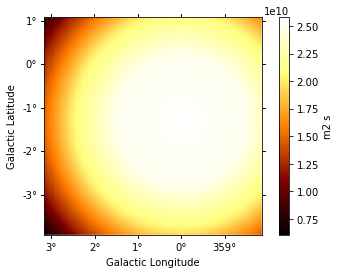

In [15]:
exposure = make_map_exposure_true_energy(
    pointing=pointing.radec, livetime=LIVETIME, aeff=irfs["aeff"], geom=geom
)
exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

We estimate the background from the tabulated IRFs:

In [16]:
background = make_map_background_irf(
    pointing=pointing, ontime=LIVETIME, bkg=irfs["bkg"], geom=geom
)
background_model = BackgroundModel(background)

# We freeze the background model parameters
background_model.norm.value = 1.0
background_model.tilt.value = 0.0
background_model.norm.frozen = True
background_model.tilt.frozen = True
#background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

In [17]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=OFFSET)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=0.3 * u.deg)
#psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

In [18]:
edisp = irfs["edisp"].to_energy_dispersion(
    OFFSET, e_reco=energy, e_true=energy
)
#edisp.plot_matrix();

/home/luca/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/gammapy/utils/interpolation.py:159: Warning: Interpolated values reached float32 precision limit
  "Interpolated values reached float32 precision limit", Warning


## Functions and utilities for simulation and fitting

We introduce a library of functions that will be used to iterate the analysis (simulating, fitting, storing results) for each point in the parameter space of the simulated model. 

In [19]:
def spectral_model_sim(norm, index, cutoff):
    """Normalize the model via the integral flux above 1 TeV (in Crab units, defined as in the HGPS), 
     instead of using the model amplitude, as done normally in Naima."""
    
    crab_unit = "3.8e-11 cm-2 s-1 TeV-1" # Crab flux above 1 TeV
    
    def model(x):
        particle_distribution = naima.models.ExponentialCutoffPowerLaw(x / u.eV, 10 * u.TeV, index, cutoff * u.PeV)
        radiative_model = naima.radiative.PionDecay(
                particle_distribution,
                nh = 1 / u.cm**3,
        )
        return NaimaSpectralModel(radiative_model, distance=1*u.kpc)
        
    def f_pl(x):
        return (model(x)(1*u.TeV) / crab_unit).to("") - norm

    amplitude = fsolve(f_pl, 1e32)[0]
    np.testing.assert_almost_equal(f_pl(amplitude), 0)
    return model(amplitude)

In [14]:
def simulate_datasets(model, livetime, n_obs):
    """Simulate n_obs instances of same the 3D dataset""" 

    dataset = MapDataset(
        model=model,
        exposure=exposure,
        background_model=background_model,
        psf=psf_kernel,
        edisp=edisp,
    )
    
    # Optionally inject a tilt, to study the systematics
    #dataset.background_model.tilt.value = 0.1

    seeds = np.arange(n_obs)
    datasets = []

    for idx in range(n_obs):
        dataset.fake(random_state=idx)
        datasets.append(dataset.copy())

    # restore the original tilt 
    #dataset.background_model.tilt.value = 0.0
    
    return datasets

In [15]:
def fit_dataset(dataset, model):
        """ Fit a 3D dataset assuming a model. We don't loop here, 
         so as to be able to parallelize the job with joblib  """  
        dataset = dataset.copy()
        model = model.copy()
        dataset.model = model
        fit = Fit([dataset])
        result = fit.run(optimize_opts={"print_level": 0})
        results_dict = {"stat" : result.total_stat, "success" : result.success}
        for name in dataset.parameters.names:
            results_dict.update({name : dataset.parameters[name].value})
        #results_dict.update({"covariance" : result.parameters.covariance})
        if 'nan' in results_dict.values() and result.success != False:
            results_dict["success"] = False

        return results_dict

## Simulated models

In [16]:
spatial_model_sim = PointSpatialModel(lon_0=spatial_model_position_sim.icrs.ra, lat_0=spatial_model_position_sim.icrs.dec)

In [17]:
indexes = [1.7, 2.0, 2.3]
norms = [0.004, 0.008, 0.016, 0.024, 0.032, 0.040, 0.048, 0.050] # Crab
cutoffs = [0.5, 1, 2] # PeV

## Fitted models

In [18]:
spatial_model_fit = PointSpatialModel(
    lon_0=spatial_model_sim.position.icrs.ra + 0.05 * u.deg, 
    lat_0=spatial_model_sim.position.icrs.dec - 0.02 * u.deg
)
spatial_model_fit.lon_0.frozen = False
spatial_model_fit.lat_0.frozen = False

spatial_model_fit.lon_0.min = spatial_model_fit.lon_0.value - 0.1
spatial_model_fit.lon_0.max = spatial_model_fit.lon_0.value + 0.1
spatial_model_fit.lat_0.min = spatial_model_fit.lat_0.value - 0.1
spatial_model_fit.lat_0.max = spatial_model_fit.lat_0.value + 0.1

In [19]:
# Powerlaw model
particle_distribution = naima.models.PowerLaw(1e32 / u.eV, 10 * u.TeV, 2.0)
radiative_model = naima.radiative.PionDecay(
        particle_distribution,
        nh = 1 / u.cm**3,
)
spectral_model_pl_fit = NaimaSpectralModel(radiative_model, distance=1*u.kpc)
sky_model_pl_fit = SkyModel(spatial_model=spatial_model_fit, spectral_model=spectral_model_pl_fit)
#print(sky_model_pl_fit)

In [20]:
# ECPL model
particle_distribution = naima.models.ExponentialCutoffPowerLaw(1e32 / u.eV, 10 * u.TeV, 2.0, 1* u.PeV)
radiative_model = naima.radiative.PionDecay(
        particle_distribution,
        nh = 1 / u.cm**3,
)
spectral_model_ecpl_fit = NaimaSpectralModel(radiative_model, distance=1*u.kpc)
sky_model_ecpl_fit = SkyModel(spatial_model=spatial_model_fit, spectral_model=spectral_model_ecpl_fit)
#print(sky_model_ecpl_fit)

## Analysis iteration

In [ ]:
%%capture --no-stdout --no-display 
# This magic is intended to capture the annoying stderr (if there are errors, they are stored in the fails list)

n_obs = 500
results_dictionaries = []
num_cores = 8

for norm, index, cutoff in itertools.product(norms[::3], indexes, cutoffs):
    model_sim = spectral_model_sim(norm, index, cutoff)
    sky_model_sim = SkyModel(spatial_model=spatial_model_sim, spectral_model=model_sim)
    datasets = simulate_datasets(sky_model_sim, LIVETIME, n_obs) 

    spectral_model_pl_fit.amplitude.min = 1e27
    spectral_model_pl_fit.amplitude.max = 1e40
    spectral_model_pl_fit.e_0.frozen = True
    spectral_model_pl_fit.alpha.min = 0.0
    spectral_model_pl_fit.alpha.max = 6.0
    list_of_dicts_0 = Parallel(n_jobs=num_cores)(delayed(fit_dataset)(dataset, sky_model_pl_fit) for dataset in datasets)

    spectral_model_ecpl_fit.amplitude.min = 1e27
    spectral_model_ecpl_fit.amplitude.max = 1e40
    spectral_model_ecpl_fit.alpha.min = 0.0
    spectral_model_ecpl_fit.alpha.max = 6.0
    spectral_model_ecpl_fit.e_cutoff.min = 0.0
    spectral_model_ecpl_fit.e_cutoff.max = 2e4 # 20 PeV seems high enough
    spectral_model_ecpl_fit.e_0.frozen = True
    spectral_model_ecpl_fit.beta.frozen = True
    list_of_dicts_1 = Parallel(n_jobs=num_cores)(delayed(fit_dataset)(dataset, sky_model_ecpl_fit) for dataset in datasets)
    results_dictionaries.append(
    {
        'index' : index,
        'norm' : norm,
        'cutoff' : cutoff,
        'list_of_dicts_0' : list_of_dicts_0,
        'list_of_dicts_1' : list_of_dicts_1,
    }
    )
    print(index, norm, cutoff)
    # Save the results dictionary. We do it in the same cell of the loop: this way, we have some output even when aborting
    np.save('results_dictionary_3d_naima', results_dictionaries)